# Load data

In [2]:
import pandas as pd
import numpy as np
import loompy as lp
import matplotlib.pyplot as plt
import scipy
import scanpy as sc

In [3]:
dataset_meta = 'pbmc_1k_v3'
bcs_filtered_loc = f'/home/ggorin/count_data/{dataset_meta}/counts_filtered/spliced.barcodes.txt'
data_raw_loc =  f'/home/ggorin/count_data/{dataset_meta}/counts_unfiltered/adata.loom'
raw_data = sc.read_loom(data_raw_loc)

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]

/home/mffang/miniconda3/envs/python_3.9/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [ ]:
bcs_filtered = pd.read_csv(bcs_filtered_loc,header=None)
filtered_idx = raw_data.obs['barcode'].isin(np.asarray(bcs_filtered).squeeze())
background_data = raw_data[~filtered_idx]
background_data.write_loom('data/pbmc_1k_v3_empty.loom')

In [5]:
adata = raw_data[filtered_idx]

# Filtered droplets

In [6]:
data = adata.layers[spliced_layer].toarray()
gene_mask = (np.mean(data,axis=0)>0) & (np.var(data,axis=0)>0) 
X = data[:,gene_mask]
n,p = X.shape
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
s = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print(s)

0.4738271971435195


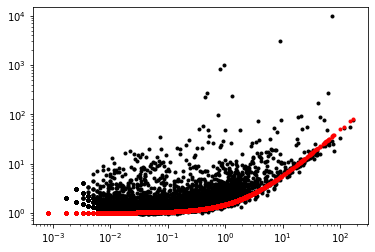

In [7]:
mean = X.mean(axis=0)
var = X.var(axis=0)
plt.loglog(mean, var/mean,'k.');
plt.loglog(mean, 1+s*mean,'r.');

# Background data

In [8]:
data = background_data.layers[spliced_layer].toarray()
gene_mask = (np.mean(data,axis=0)>0) & (np.var(data,axis=0)>0) 
X = data[:,gene_mask]
n,p = X.shape
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
s = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print(s)

2.3518886503831204


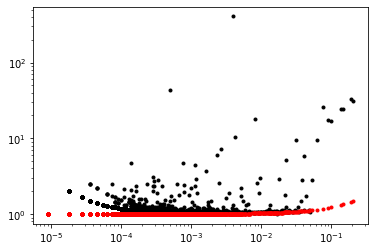

In [9]:
mean = X.mean(axis=0)
var = X.var(axis=0)
plt.loglog(mean, var/mean,'k.');
plt.loglog(mean, 1+s*mean,'r.');

## Check total counts

In [10]:
empty_droplets = raw_data.layers[spliced_layer][~filtered_idx,:].toarray()
total_counts = np.sum(empty_droplets,axis=1)
print(total_counts.max())
print(total_counts.mean(),total_counts.var())

908.0
5.509911 275.34988


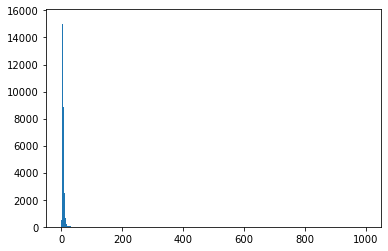

In [10]:
res = plt.hist(total_counts,bins=np.arange(0,1000,1)-0.5);
epmf = res[0]

**The distribution of total counts of "empty" droplets has a long tail**

## Possionion regime

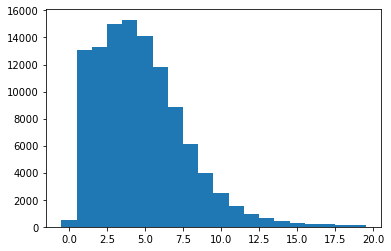

In [11]:
res = plt.hist(total_counts,bins=np.arange(0,21,1)-0.5)
epmf_20 = res[0]

In [12]:
#lam = np.arange(0,20).reshape((1,-1))@epmf.reshape((-1,1))/epmf_20.sum()
#lam = lam[0][0]
lam = total_counts.mean()

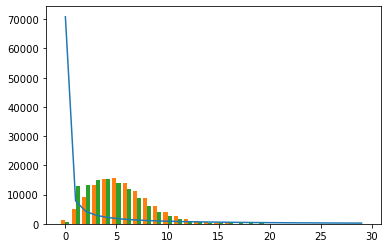

In [13]:
from scipy.stats import poisson, nbinom

sigma2 = total_counts.var() #lam + s*lam**2
p = lam/sigma2
n = lam**2/(sigma2-lam)
prob = nbinom.pmf(np.arange(30), n, p)

c=0.5
x = np.random.poisson(c*np.random.poisson(lam/c,size=110031))

plt.plot(np.arange(30),prob*110031)
plt.hist([x,total_counts],bins=np.arange(0,31,1)-0.5);

In [14]:
print((x>20).sum(),(total_counts>20).sum())

7 967


## Power law regime

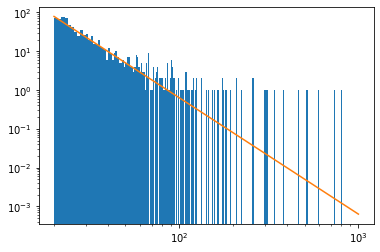

In [15]:
plt.hist(total_counts,bins=np.arange(20,1000,1));
plt.xscale('log')
plt.yscale('log')
plt.plot(np.arange(20,1000,1),10**5.8*np.arange(20.0,1000,1)**-3);

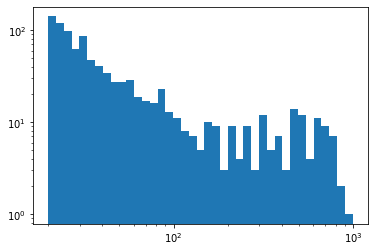

In [16]:
plt.hist(total_counts,bins=np.exp(np.arange(3,7,0.1)));
plt.xscale('log')
plt.yscale('log')
#plt.plot(np.arange(20,1000,1),10**5.8*np.arange(20.0,1000,1)**-3);

In [17]:
from scipy.stats import zipf

#pmf_z = zipf.pmf(k=np.arange(0,999,1), a=3)
z = zipf.rvs(a=2.5,size=110000)

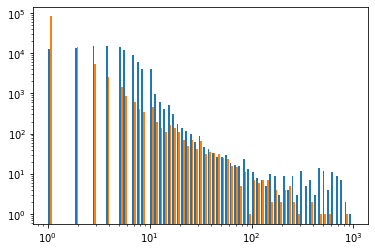

In [18]:
x_=np.exp(np.arange(0,7,0.1))
plt.hist([total_counts,z],bins=x_);
plt.xscale('log')
plt.yscale('log')

## Are abundances different?

In [14]:
filled = empty_droplets[total_counts>20]
empty = empty_droplets[(total_counts<=20)&(total_counts>0)]

In [16]:
filled_mean = (filled/filled.sum(axis=1,keepdims=True)).mean(axis=0)
empty_mean = (empty/empty.sum(axis=1,keepdims=True)).mean(axis=0)

In [17]:
filled.mean()/empty.mean()

19.061483

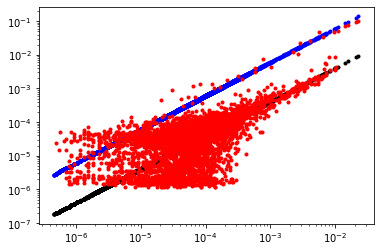

In [22]:
plt.loglog(empty_mean, 0.4*empty_mean,'k.');
plt.loglog(empty_mean, 6*empty_mean,'b.');
plt.loglog(empty_mean, filled_mean,'r.');

(0.0, 0.01)

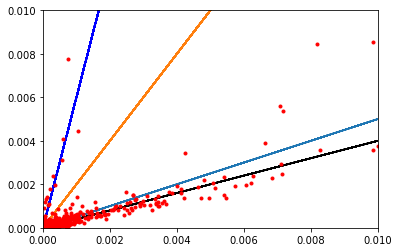

In [23]:
plt.plot(empty_mean, 0.4*empty_mean,'k-');
plt.plot(empty_mean, 0.5*empty_mean,'-');
plt.plot(empty_mean, 2*empty_mean,'-');
plt.plot(empty_mean, 6*empty_mean,'b-');
plt.plot(empty_mean, filled_mean,'r.');
plt.xlim((0,0.01))
plt.ylim((0,0.01))

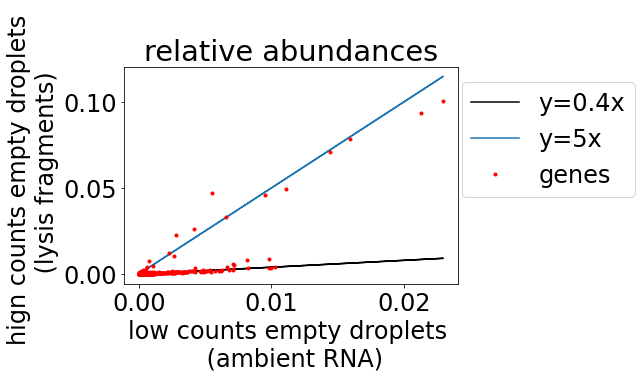

In [43]:
plt.rcParams['font.size'] = '24'

plt.plot(empty_mean, 0.4*empty_mean,'k-',label="y=0.4x");
plt.plot(empty_mean, 5*empty_mean,'-',label="y=5x");
plt.plot(empty_mean, filled_mean,'r.',label="genes");
plt.xlabel("low counts empty droplets \n (ambient RNA)")
plt.ylabel("hign counts empty droplets \n (lysis fragments)")
plt.title("relative abundances")
plt.legend(loc=(1.01,0.4));

In [44]:
cells = adata.layers[spliced_layer].toarray()
cells_mean = (cells/cells.sum(axis=1,keepdims=True)).mean(axis=0)

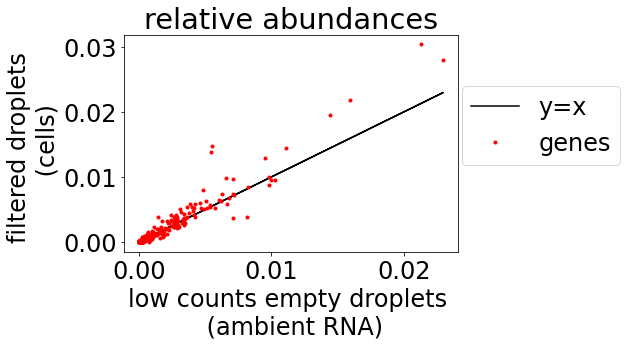

In [47]:
plt.rcParams['font.size'] = '24'

plt.plot(empty_mean, 1*empty_mean,'k-',label="y=x");
#plt.plot(empty_mean, 2*empty_mean,'-');
#plt.plot(empty_mean, 0.5*empty_mean,'-');
plt.plot(empty_mean, cells_mean,'r.',label="genes");
plt.xlabel("low counts empty droplets \n (ambient RNA)")
plt.ylabel("filtered droplets \n (cells)")
plt.title("relative abundances")
plt.legend(loc=(1.01,0.4));

(0.0, 0.01)

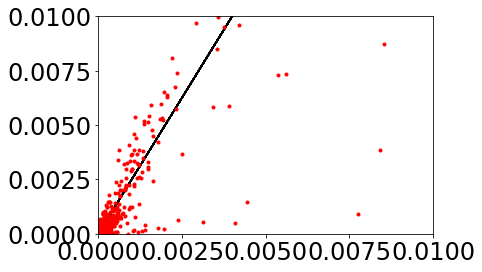

In [46]:
plt.plot(filled_mean, 2.5*filled_mean,'k-');
plt.plot(filled_mean, cells_mean,'r.');
plt.xlim((0,0.01))
plt.ylim((0,0.01))

# Find outlier genes

In [67]:
gene_names = pd.read_csv(f'/home/ggorin/count_data/{dataset_meta}/counts_unfiltered/spliced.genes.txt',header=None)

gene_info = pd.read_csv('data/biomart_export.csv',header=0)
gene_info

,Gene stable ID,Gene name,Gene description
0,ENSG00000210049,MT-TF,mitochondrially encoded tRNA-Phe (UUU/C) [Sour...
1,ENSG00000211459,MT-RNR1,mitochondrially encoded 12S rRNA [Source:HGNC ...
2,ENSG00000210077,MT-TV,mitochondrially encoded tRNA-Val (GUN) [Source...
3,ENSG00000210082,MT-RNR2,mitochondrially encoded 16S rRNA [Source:HGNC ...
4,ENSG00000209082,MT-TL1,mitochondrially encoded tRNA-Leu (UUA/G) 1 [So...
...,...,...,...
69294,ENSG00000162437,RAVER2,"ribonucleoprotein, PTB binding 2 [Source:HGNC ..."
69295,ENSG00000122432,SPATA1,spermatogenesis associated 1 [Source:HGNC Symb...
69296,ENSG00000284882,NaN,novel transcript
69297,ENSG00000289881,NaN,novel transcript


In [93]:
outlier_gene_idx = (filled_mean > 3*empty_mean) & (filled_mean > 0.001)
print(outlier_gene_idx.sum())
outlier_genes = gene_names[outlier_gene_idx]
outlier_genes = outlier_genes[0].tolist()
outlier_genes_ = [ gene.split(".")[0] for gene in outlier_genes]
gene_info[gene_info["Gene stable ID"].isin(outlier_genes_)]

24


,Gene stable ID,Gene name,Gene description
5,ENSG00000198888,MT-ND1,mitochondrially encoded NADH:ubiquinone oxidor...
9,ENSG00000198763,MT-ND2,mitochondrially encoded NADH:ubiquinone oxidor...
15,ENSG00000198804,MT-CO1,mitochondrially encoded cytochrome c oxidase I...
18,ENSG00000198712,MT-CO2,mitochondrially encoded cytochrome c oxidase I...
20,ENSG00000228253,MT-ATP8,mitochondrially encoded ATP synthase membrane ...
21,ENSG00000198899,MT-ATP6,mitochondrially encoded ATP synthase membrane ...
22,ENSG00000198938,MT-CO3,mitochondrially encoded cytochrome c oxidase I...
24,ENSG00000198840,MT-ND3,mitochondrially encoded NADH:ubiquinone oxidor...
26,ENSG00000212907,MT-ND4L,mitochondrially encoded NADH:ubiquinone oxidor...
27,ENSG00000198886,MT-ND4,mitochondrially encoded NADH:ubiquinone oxidor...


In [94]:
outlier_gene_idx = (filled_mean > 3*empty_mean) & (filled_mean > 0.0001)
print(outlier_gene_idx.sum())
outlier_genes = gene_names[outlier_gene_idx]
outlier_genes = outlier_genes[0].tolist()
outlier_genes_ = [ gene.split(".")[0] for gene in outlier_genes]
gene_info[gene_info["Gene stable ID"].isin(outlier_genes_)]

55


,Gene stable ID,Gene name,Gene description
5,ENSG00000198888,MT-ND1,mitochondrially encoded NADH:ubiquinone oxidor...
9,ENSG00000198763,MT-ND2,mitochondrially encoded NADH:ubiquinone oxidor...
15,ENSG00000198804,MT-CO1,mitochondrially encoded cytochrome c oxidase I...
18,ENSG00000198712,MT-CO2,mitochondrially encoded cytochrome c oxidase I...
20,ENSG00000228253,MT-ATP8,mitochondrially encoded ATP synthase membrane ...
21,ENSG00000198899,MT-ATP6,mitochondrially encoded ATP synthase membrane ...
22,ENSG00000198938,MT-CO3,mitochondrially encoded cytochrome c oxidase I...
24,ENSG00000198840,MT-ND3,mitochondrially encoded NADH:ubiquinone oxidor...
26,ENSG00000212907,MT-ND4L,mitochondrially encoded NADH:ubiquinone oxidor...
27,ENSG00000198886,MT-ND4,mitochondrially encoded NADH:ubiquinone oxidor...


**plot MT genes distribution**

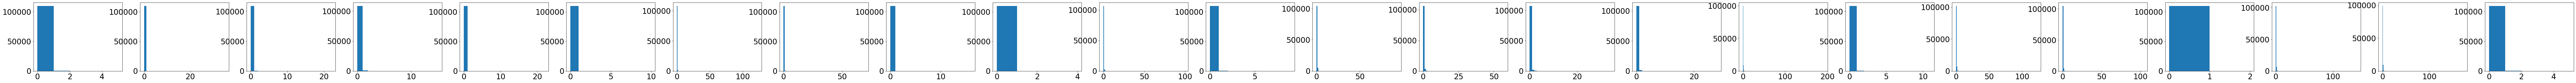

In [51]:
x = empty_droplets[:,outlier_gene_idx]
fig, ax = plt.subplots(1,x.shape[1],figsize=(6*x.shape[1],4))
for i in range(x.shape[1]):
    ax[i].hist(x[:,i],bins=np.arange(x[:,i].max()+1))    

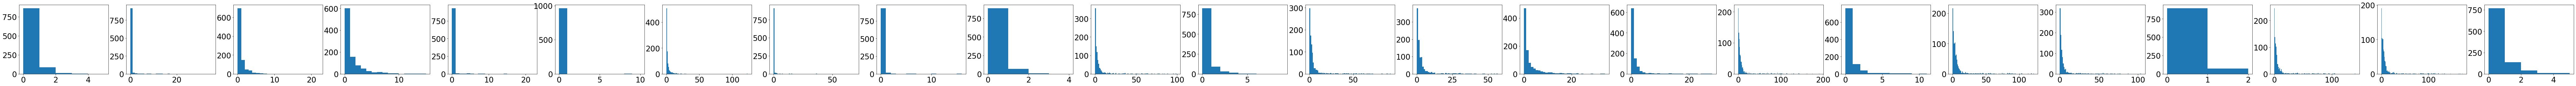

In [52]:
x = filled[:,outlier_gene_idx]
fig, ax = plt.subplots(1,x.shape[1],figsize=(6*x.shape[1],4))
for i in range(x.shape[1]):
    ax[i].hist(x[:,i],bins=np.arange(x[:,i].max()+1))    

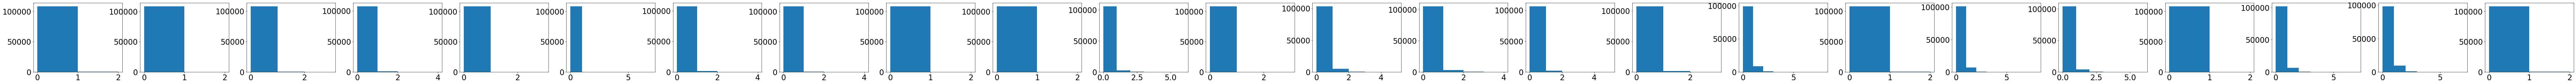

In [53]:
x = empty[:,outlier_gene_idx]
fig, ax = plt.subplots(1,x.shape[1],figsize=(6*x.shape[1],4))
for i in range(x.shape[1]):
    ax[i].hist(x[:,i],bins=np.arange(x[:,i].max()+1))  

In [74]:
nonMT_ID = []
for i in range(len(gene_info)):
    if type(gene_info['Gene name'][i]) is str:
        if gene_info['Gene name'][i][:3] != "MT-":
            nonMT_ID.append(gene_info['Gene stable ID'][i])

In [83]:
gene_names_ = pd.DataFrame([ gene.split(".")[0] for gene in gene_names[0]])
normal_gene_idx = gene_names_[0].isin(nonMT_ID)

In [85]:
#normal_gene_idx = (filled_mean < 0.5*empty_mean) & (empty_mean > 0)
#print(normal_gene_idx.sum())

data = empty_droplets[:,normal_gene_idx]
gene_mask = (np.mean(data,axis=0)>0) & (np.var(data,axis=0)>0) 
X = data[:,gene_mask]
n,p = X.shape
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
s = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print(s)

2.2756820756971092


In [101]:
normal_gene_idx = (filled_mean < 0.45*empty_mean) & (empty_mean > 0)
print(normal_gene_idx.sum())

data = empty_droplets[:,normal_gene_idx]
gene_mask = (np.mean(data,axis=0)>0) & (np.var(data,axis=0)>0) 
X = data[:,gene_mask]
n,p = X.shape
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
s = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print(s)

9225
0.4437724743470413


In [86]:
## only ambient RNA

data = empty
gene_mask = (np.mean(data,axis=0)>0) & (np.var(data,axis=0)>0) 
X = data[:,gene_mask]
n,p = X.shape
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
s = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print(s)

25231
0.1584894305741039


In [ ]:
backgroud_total_counts = data.sum(axis=1)

In [ ]:
plt.hist(backgroud_total_counts,bins=np.arange(int(np.amax(backgroud_total_counts))+1));
plt.yscale('log')